In [1]:
import sys
import pandas as pd

sys.path.append('/opt/hydra/')

import library.analysis as hydra

In [2]:
exp_path = '../data/treehouse-synovial-log2TPM1-V9.tsv'
mm_path = '../data/synovial-output/MultiModalGenes'

In [3]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [4]:
import numpy as np

mm = hydra.EnrichmentAnalysis(mm_path,
                              exp_path,
                              min_prob_filter=0.29,
                              gmt_path='GO')

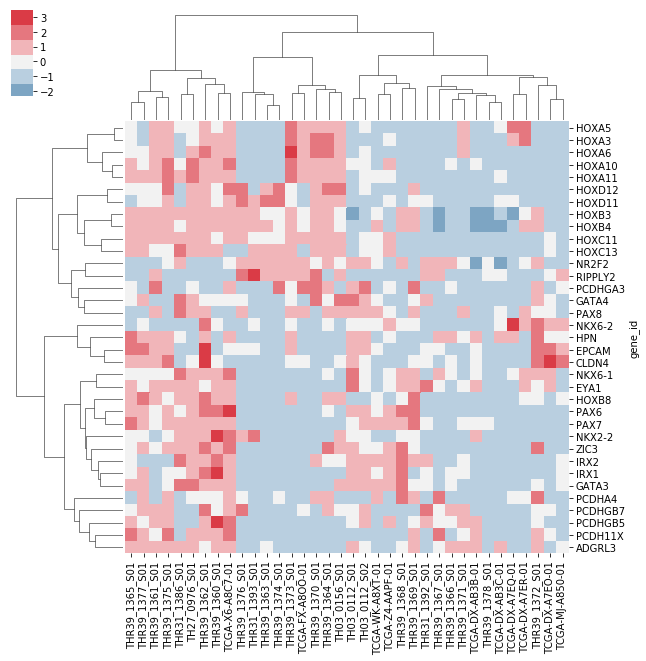

In [5]:
hclust = hydra.HClust(exp.reindex(mm.get_enriched_term_genes()))
hclust.plot()

In [6]:
clus = hydra.MultivariateMixtureModel(data=exp.reindex(mm.get_enriched_term_genes()),
                                      center=True,
                                      gamma=5.0,
                                      variance=2.0,
                                      K=1)

In [7]:
cluster_feat = clus.get_cluster_features(exp=exp, 
                                         gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [8]:
assign = pd.DataFrame(columns=['sample', 'cluster'])
for s, a in zip(exp.columns, clus.get_assignments(exp.reindex(mm.get_enriched_term_genes()))):
    assign.loc[len(assign), :] = [s, a + 1]
    
assign.set_index('sample', inplace=True)

In [9]:
pth = '../data/synovial-fusion.tsv'
fusion = pd.read_csv(pth, sep='\t', index_col=0)

m = [[0, 0, 0], [0, 0, 0]]

fusion_samples = {'SSX1': [], 'SSX2': []}
for sample in assign.index.values:
    if sample == 'TCGA-DX-A7EQ-01':
        continue
    c = assign.loc[sample, 'cluster']
    f = fusion.loc[sample, 'fusion']
    if f == 'SSX1':
        m[1][c - 1] += 1
        fusion_samples['SSX1'].append(sample)
        
    elif f == 'SSX2':
        m[0][c - 1] += 1
        fusion_samples['SSX2'].append(sample)
    
    else:
        raise ValueError()

print """
> library(stats)
> library(base)
> x <- rbind(c(4, 5, 2), c(13, 5, 6))
> x
     [,1] [,2] [,3]
[1,]    4    5    2
[2,]   13    5    6
> fisher.test(x)

	Fisher's Exact Test for Count Data

data:  x
p-value = 0.3237
alternative hypothesis: two.sided
"""


> library(stats)
> library(base)
> x <- rbind(c(4, 5, 2), c(13, 5, 6))
> x
     [,1] [,2] [,3]
[1,]    4    5    2
[2,]   13    5    6
> fisher.test(x)

	Fisher's Exact Test for Count Data

data:  x
p-value = 0.3237
alternative hypothesis: two.sided



In [10]:
for sample in exp.columns:
    c, res = clus.sub_cluster_gsea(exp[sample],
                                   gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt',
                                   debug=True)
    
    mask = (res['padj'] < 0.05) & (res['NES'] > 0)
    if len(res[mask]) > 0:
        print res[mask]

gene_id
NKX6-1    1.776003
GATA4     1.768636
EYA1      1.304111
HPN       1.254954
NR2F2     1.174235
dtype: float64
gene_id
PCDHGA3    1.689024
NR2F2      1.380922
HPN        1.053729
PAX8       0.907205
PCDHGB5    0.886659
dtype: float64
gene_id
NKX2-2     2.250990
IRX1       1.990050
PCDHGB5    1.795357
IRX2       1.195250
PAX6       1.122127
dtype: float64
gene_id
PCDHGA3    1.740084
RIPPLY2    1.690409
HOXA5      1.117326
PCDHGB7    1.048359
HOXA6      0.898003
dtype: float64
gene_id
NKX6-2     2.901783
CLDN4      2.351916
EPCAM      1.933309
PCDHGB7    1.587005
IRX1       1.500218
dtype: float64
gene_id
ADGRL3     2.295344
HOXD11     0.928418
NR2F2      0.307163
EYA1       0.158321
RIPPLY2    0.107109
dtype: float64
gene_id
NKX6-2    2.226208
NKX6-1    2.067976
ZIC3      1.968073
PAX6      1.653339
HOXB8     1.624476
dtype: float64
gene_id
HPN        1.382910
PCDH11X    1.371439
PAX7       1.146198
EPCAM      1.057975
PCDHGB5    0.868279
dtype: float64
gene_id
PCDHGB7    1.52832

In [11]:
import scikit_posthocs as sp


pth = '../data/treehouse-synovial-log2TPM1-V9.estimate.gct'
est = pd.read_csv(pth, sep='\t', comment='#', header=1, index_col=0)
est.drop('Description', axis=1, inplace=True)
est.columns = [x.replace('.', '-') for x in est.columns]

pth = '../data/xCell_treehouse-synovial-log2TPM1-V9_xCell_1733072319.txt'
xcell = pd.read_csv(pth, sep='\t', index_col=0)
xcell.columns = [x.replace('.', '-') for x in xcell.columns]

immune_groups = dict((group, []) for group in assign['cluster'].unique())
immune = pd.DataFrame(columns=['sample', 'cluster', 'source', 'feature', 'value'])
for sample in assign.index.values:        
    assignment = assign.loc[sample, 'cluster']
    
    immune_groups[assignment].append(sample)
    
    for score in ['StromalScore', 'ImmuneScore', 'ESTIMATEScore']:
        _est = est.loc[score, sample].item()
        immune.loc[len(immune), :] = [sample, assignment, 'Estimate', score, _est]
        
    immune.loc[len(immune), :] = [sample, assignment, 
                                'Estimate', 'TumorPurity', 
                                np.cos(0.6049872018 + 0.0001467884 * _est)]
    
    for cell, value in xcell[sample].iteritems():
            immune.loc[len(immune), :] = [sample, assignment, 'xCell', cell, value]

skip = ['P-value', 'Pearson Correlation', 'RMSE']        
immune = immune[~immune['feature'].isin(skip)]        
immune['value'] = pd.to_numeric(immune['value'])

In [12]:
import collections
from scipy.stats import kruskal, f_oneway
import itertools
sigs = collections.defaultdict(list)

p_values = pd.DataFrame(columns=['source', 
                                 'feature', 
                                 'A', 
                                 'B', 
                                 'holm p-value'])

for source, rows in immune.groupby('source'):
    print source
    nfeatures = len(rows['feature'].unique())
    alpha = 1 - (1 - 0.05) ** (1.0 / nfeatures)
    for feature in rows['feature'].unique():
        print(feature)
        groups3 = []
        for i, rows in immune[immune['feature'] == feature].groupby('cluster'):
            groups3.append(list(rows['value'].values))
            print i, rows['value'].mean()
    
        try:
            stat, pvalue = kruskal(*groups3)
            print(feature, pvalue, pvalue < alpha)
        
        except Exception as e:
            print e
            continue
    
        if pvalue < alpha:
            sigs[source].append(feature)
            
            try:
                res = sp.posthoc_mannwhitney(groups3, 
                                             p_adjust='holm')
                
            except Exception as e:
                print e
                continue
            
            for i, j in itertools.combinations(range(len(groups3)),
                                               2):
                
                if i == j:
                    continue 
                    
                p_values.loc[len(p_values), :] = [source,
                                                  feature,
                                                  i, 
                                                  j,
                                                  res.iloc[i, j]]

Estimate
StromalScore
1 -431.83782438270754
2 -728.7951662321246
3 -835.3788406401089
('StromalScore', 0.10019323591496009, False)
ImmuneScore
1 -554.452666743701
2 -504.81392494247825
3 -561.1865406182391
('ImmuneScore', 0.9650116152979549, False)
ESTIMATEScore
1 -1540.7967931642274
2 -1738.464670662536
3 -1957.7987718765887
('ESTIMATEScore', 0.5996520007276783, False)
TumorPurity
1 0.9202470049024305
2 0.9330034801345299
3 0.9482426121528851
('TumorPurity', 0.5996520007276783, False)
xCell
Adipocytes
1 0.007717647058823529
2 0.0018727272727272727
3 0.013162499999999999
('Adipocytes', 0.3208237373593676, False)
Astrocytes
1 0.0
2 0.0
3 0.0
All numbers are identical in kruskal
B-cells
1 0.005829411764705882
2 0.012036363636363638
3 0.011625
('B-cells', 0.28205656823486497, False)
Basophils
1 0.043888235294117645
2 0.04552727272727272
3 0.04485
('Basophils', 0.9700395487539514, False)
CD4+ T-cells
1 0.0
2 0.0
3 0.0
All numbers are identical in kruskal
CD4+ Tcm
1 0.011811764705882353
2 0

0 Mast cells


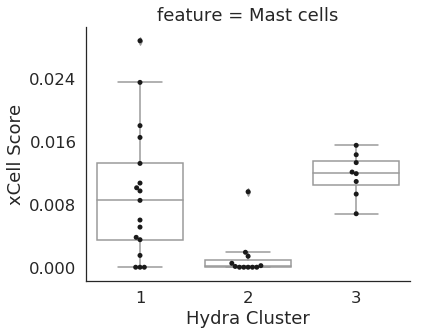

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5, style='white')

interest = ['Mast cells']
mask = (immune['source'] == 'xCell') & (immune['feature'].isin(interest))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                color='white',
                sharex=False,
                sharey=False,
                data=t,
                aspect=1.25)

for i, feature in enumerate(t['feature'].unique()):
    print i, feature
    sns.swarmplot(x='cluster',
                  y='value',
                  color='k',
                  size=5,
                  data=t[t['feature'] == feature],
                  ax=g.axes[i])

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('xCell Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

#pth = 'img/CIBERSORT-Plots.svg'
#plt.savefig(pth, format='svg', bbox_inches='tight')

#pth = 'img/CIBERSORT-Plots.png'
#plt.savefig(pth, format='png', bbox_inches='tight')